# Image classification using Convolutional neural networks


#Binary Classification

## Introduction

Computer vision is the practice of writing algorithms which can discover patterns in visual data

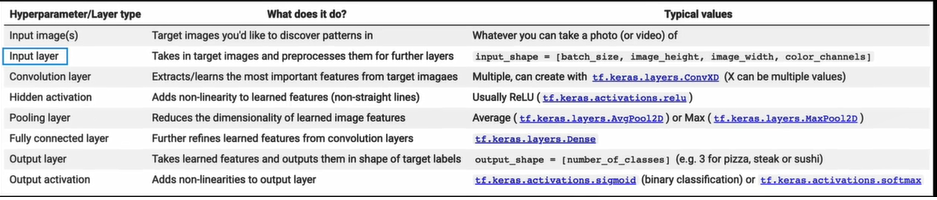

## Get the data
The images we're working with are from Food101 [101 different classes of food](https://www.kaggle.com/datasets/dansbecker/food-101)

However we've modified it to only use pizza and steak using the image data [modification notebook](https://github.com/mrdbourke/tensorflow-deep-learning/tree/main/extras) 
We are starting with smaller dataset so we can experiment quickly and figure what works( or what doesn't work) before scaling up

In [ ]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

zip_ref=zipfile.ZipFile('pizza_steak.zip')
zip_ref.extractall()
zip_ref.close()

--2022-07-13 11:43:46--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.251.12.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: â€˜pizza_steak.zipâ€™

pizza_steak.zip     100%[===================>] 104.47M   282MB/s    in 0.4s    

2022-07-13 11:43:47 (282 MB/s) - â€˜pizza_steak.zipâ€™ saved [109540975/109540975]



## Inspect the data

In [ ]:
import os 
#list number of files

for dirpath,dirnames,filenames in os.walk("pizza_steak"):
  print(f'There are {len(dirnames)} directories {len(filenames)} images in {dirpath}')

There are 2 directories 0 images in pizza_steak
There are 2 directories 0 images in pizza_steak/train
There are 0 directories 750 images in pizza_steak/train/pizza
There are 0 directories 750 images in pizza_steak/train/steak
There are 2 directories 0 images in pizza_steak/test
There are 0 directories 250 images in pizza_steak/test/pizza
There are 0 directories 250 images in pizza_steak/test/steak


In [ ]:
num_steak_images_train=len(os.listdir('pizza_steak/train/steak'))

In [ ]:
num_steak_images_train

750

To visualize our images, first let's get the class names programmatically

In [ ]:
import pathlib
import numpy as np
data_dir=pathlib.Path('pizza_steak/train')
class_names=np.array(sorted([item.name for item in data_dir.glob('*')]))

In [ ]:
class_names

array(['pizza', 'steak'], dtype='<U5')

In [ ]:
#Lets visualize images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir,target_class):
  #set up the target directory
  target_folder=target_dir+target_class

  #random image path
  ran_image=random.sample(os.listdir(target_folder),1)
  #reading and plotting using matplotlib

  img=mpimg.imread(target_folder+'/'+ ran_image[0]) #reads as array
  plt.imshow(img)
  plt.title(target_class)
  plt.axis('off')
  print(f'image shape : {img.shape}')



image shape : (512, 382, 3)


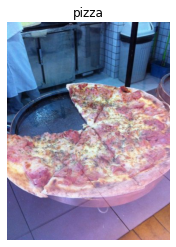

In [ ]:
view_random_image(target_dir='pizza_steak/train/',target_class='pizza')

## An end-to-end example

Let's build a convolutional neural network to find the patterns in our images:

* Load our images
* Preprocess our images
* Build a CNN to find patterns in our images
* Compile our CNN
* Fit the CNN to training data

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#set the random seed
tf.random.set_seed(42)

# recale preprocessses the data (scaling/normalization)

train_datagen=ImageDataGenerator(rescale=1./255)
valid_datagen=ImageDataGenerator(rescale=1./255)

#path to data directories
train_dir='/content/pizza_steak/train'
test_dir='/content/pizza_steak/test'

#Import data from directories and turn into the batches
#target_size reshapes the images in 224 x 224, class_mode tells no of data classes
train_data=train_datagen.flow_from_directory(directory=train_dir,
                                             batch_size=32,
                                             target_size=(224,224),
                                             class_mode='binary',
                                             seed=42)
valid_data=valid_datagen.flow_from_directory(directory=test_dir,
                                             batch_size=32,
                                             target_size=(224,224),
                                             class_mode='binary',
                                             seed=42)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [ ]:
len(train_data),1500/32  #totalimages/batch_size
#47 are the number of batches in training data. Batches are used so that way the
#data can fit in our memory. If all images are used at once then computer might
#run out of memory

(47, 46.875)

In [ ]:
#Build a CNN model
#model can still be improved by adding more units and increasing the image input
#size
tf.random.set_seed(42)
model=tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=10,
                         kernel_size=3,
                         activation='relu',
                         input_shape=(224,224,3)),
        tf.keras.layers.Conv2D(10,3,activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=2,
                           padding='valid'),
        tf.keras.layers.Conv2D(10,3,activation='relu'),
        tf.keras.layers.Conv2D(10,3,activation='relu'),
        tf.keras.layers.MaxPool2D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1,activation='sigmoid')
        ])

#Compile
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
#flow_from_directory reads images and labels for us and can be directly used
history=model.fit(train_data,
                  epochs=10,
                  steps_per_epoch=len(train_data),
                  validation_data=valid_data,
                  validation_steps=len(valid_data))

Epoch 1/10
47/47 [==============================] - 23s 206ms/step - loss: 0.5596 - accuracy: 0.7093 - val_loss: 0.4385 - val_accuracy: 0.7920
Epoch 2/10
47/47 [==============================] - 10s 212ms/step - loss: 0.4169 - accuracy: 0.8180 - val_loss: 0.3522 - val_accuracy: 0.8560
Epoch 3/10
47/47 [==============================] - ETA: 0s - loss: 0.3871 - accuracy: 0.8373

KeyboardInterrupt: ignored

In [ ]:
model.evaluate(valid_data)

In [ ]:
model.summary()

## Non-CNN Model
We will use the model we built in previous section to see how it performs with this data


### First model

In [ ]:
tf.random.set_seed(42)
model2=tf.keras.Sequential([
          tf.keras.layers.Flatten(input_shape=(224,224,3)),
          tf.keras.layers.Dense(4,activation='relu'),
          tf.keras.layers.Dense(4,activation='relu'),
          tf.keras.layers.Dense(1,activation='sigmoid')    
])

model2.compile(loss='binary_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

In [ ]:
history2=model2.fit(train_data,
                     epochs=5,
                     steps_per_epoch=len(train_data),
                     validation_data=valid_data,
                     validation_steps=len(valid_data))

In [ ]:
model2.summary()

### Adding layers and increasing Units

In [ ]:
tf.random.set_seed(42)
model3=tf.keras.Sequential([
          tf.keras.layers.Flatten(input_shape=(224,224,3)),
          tf.keras.layers.Dense(100,activation='relu'),
          tf.keras.layers.Dense(100,activation='relu'),
          tf.keras.layers.Dense(100,activation='relu'),
          tf.keras.layers.Dense(1,activation='sigmoid')    
])

model3.compile(loss='binary_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

In [ ]:
history3=model3.fit(train_data,
                     epochs=5,
                     steps_per_epoch=len(train_data),
                     validation_data=valid_data,
                     validation_steps=len(valid_data))

We can see the accuracy is improving now, Let's increase learning rate and epochs

### Training for longer- More Epochs

In [ ]:
tf.random.set_seed(42)
model4=tf.keras.Sequential([
          tf.keras.layers.Flatten(input_shape=(224,224,3)),
          tf.keras.layers.Dense(100,activation='relu'),
          tf.keras.layers.Dense(100,activation='relu'),
          tf.keras.layers.Dense(100,activation='relu'),
          tf.keras.layers.Dense(1,activation='sigmoid')    
])

model4.compile(loss='binary_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

In [ ]:
history4=model4.fit(train_data,
                     epochs=10,
                     steps_per_epoch=len(train_data),
                     validation_data=valid_data,
                     validation_steps=len(valid_data))

In [ ]:
model4.evaluate(valid_data)

In [ ]:
model4.summary()

In [ ]:
# no of trainable params in nn/no of trainable params in cnn
15073201/31101

Even with 485x the no of trainable parameters the neural network is still unable to achieve the accuracy of CNN. This is why CNNs are better at image recognition

**ðŸ”‘Note**: You can think of trainable parameters as patterns a model can learn from data. Intuitively you might think, the more the better and in lots of cases it is but sometimes it is not. The difference here is two different styles of layers. Where a series of dense layers has a number of different learnable parameters connected to each other hence more trainable parameters. **A convolutional neural network seeks to sort out the most important patterns in a image** So even with less trainable parameters it still performs better or atleast same.

## Binary Classification: Let's break it down.

1. Become one with data(visualize)
2. Preprocess the data (preparing data for model cleaning/scaling/normalizing)
3. Creating a model (Start a baseline/benchmark model)
4. Fit the model
5. Evaluate the model
6. Adjust different parameters and improve the model (beat the baseline)
7. Repeat until satisfied (experiment)

### 1. Becoming one with the data

In [ ]:
#visualize the data
plt.figure()
plt.subplot(1,2,1)
steak_img=view_random_image('pizza_steak/train/','steak')
plt.subplot(1,2,2)
steak_img=view_random_image('pizza_steak/train/','pizza')

### 2. Preprocess the data (prepare it for model)

In [ ]:
#define directory dataset paths
train_dir='pizza_steak/train/'
test_dir='pizza_steak/test/'

Our next step is to turn our data into **batches**.
A batch is a small subset of data. Rather than looking at all images at one time, a model looks at just a batch which is small in number.

It does this for couple of reasons:

1. All of the images might not fit into the memory of GPU/CPU
2. Trying to learn the pattern in all images in one hit could result in the model not being able to learn very well.

Default batch size is 32. You can change this usually they are used to the power of 2.
https://twitter.com/ylecun/status/989610208497360896?s=20&t=QK4pVaSF0XUbu-ngC7GAaQ

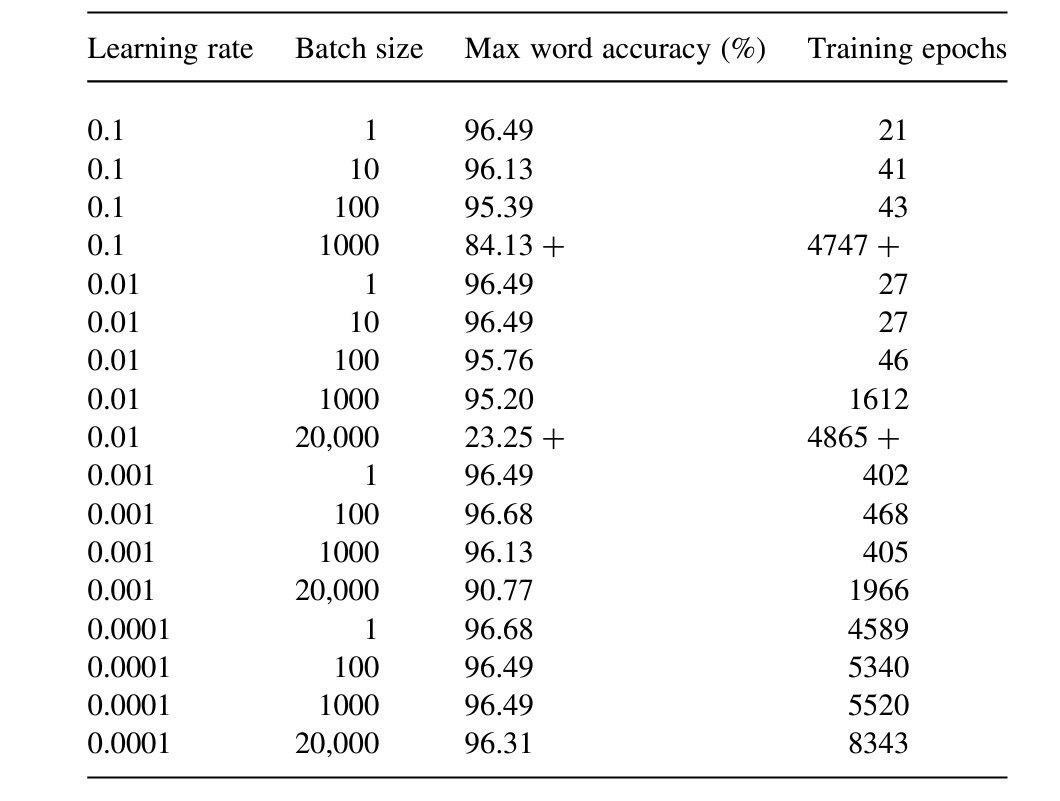

In [ ]:
!nvidia-smi

  The rescale parameter tells the [ImageDataGenerator]('https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator')(Generate batches of tensor image data with real-time data augmentation.) to divide all the pixel of loaded image by 255.0

In [ ]:
# Create train and test data generators and rescale the data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen= ImageDataGenerator(rescale=1/255.0)
test_datagen= ImageDataGenerator(rescale=1/255.0)

[Flow_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) is being used to read images from the directory. Some general parameters are directory,class_mode,batch_size,shuffle,color_mode and target

In [ ]:
#Load our image data from directories and turn them into batches
train_data=train_datagen.flow_from_directory(directory=train_dir, #directory of images
                                             target_size=(224,224), #height x width
                                             class_mode='binary', #type of data
                                             batch_size=32) #size of minibatches
#Same way you can create a validation folder and import validation data                                             
test_data=test_datagen.flow_from_directory(directory=test_dir,
                                             target_size=(224,224),
                                             class_mode='binary',
                                             batch_size=32)

In [ ]:
# get the next batch, It is not required, (just for understanding)
images,labels=train_data.next()
len(images),len(labels)

In [ ]:
#How many batches
len(train_data),1500/32

In [ ]:
#get first two images

images[:2], images[0].shape

We can look how the values are already scaled for us and the size of image is whatever we set in the flow_from_directory

In [ ]:
 #view labels 
 labels

### 3. Create a CNN model (start with a baseline)

A baseline is a relatively simple model or existing result that you setup when beginning a machine learning experimenting, you try to beat the baseline

A CNN is just stacking convolutional layers and pooling layers in different ways

**ðŸ”‘Note:** In deep learning, there are almost infinite number of architectures you could create. So one of the best ways to get started is to start with something simple and see if it works on the data and then introduce the complexity as required.

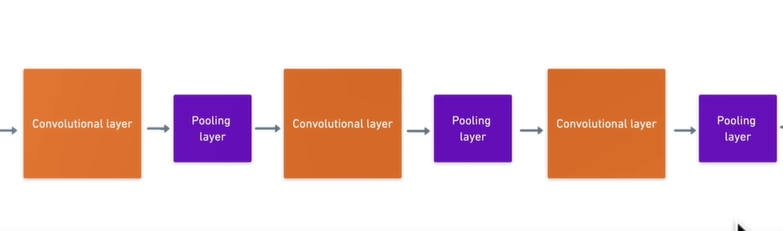

In [ ]:
 #Make the creating of our model easier
 from tensorflow.keras.optimizers import Adam
 from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPool2D,Activation
 from tensorflow.keras import Sequential

 model5= Sequential([
                    Conv2D(filters=10,
                           kernel_size=3,
                           strides=1,
                           padding='valid',
                           activation='relu',
                           input_shape=(224,224,3)),
                    Conv2D(10,3,activation='relu'), #first param is filters and second is kernel_size
                    Conv2D(10,3,activation='relu'),
                    Flatten(),
                    Dense(1,activation='sigmoid')
                    
 ])


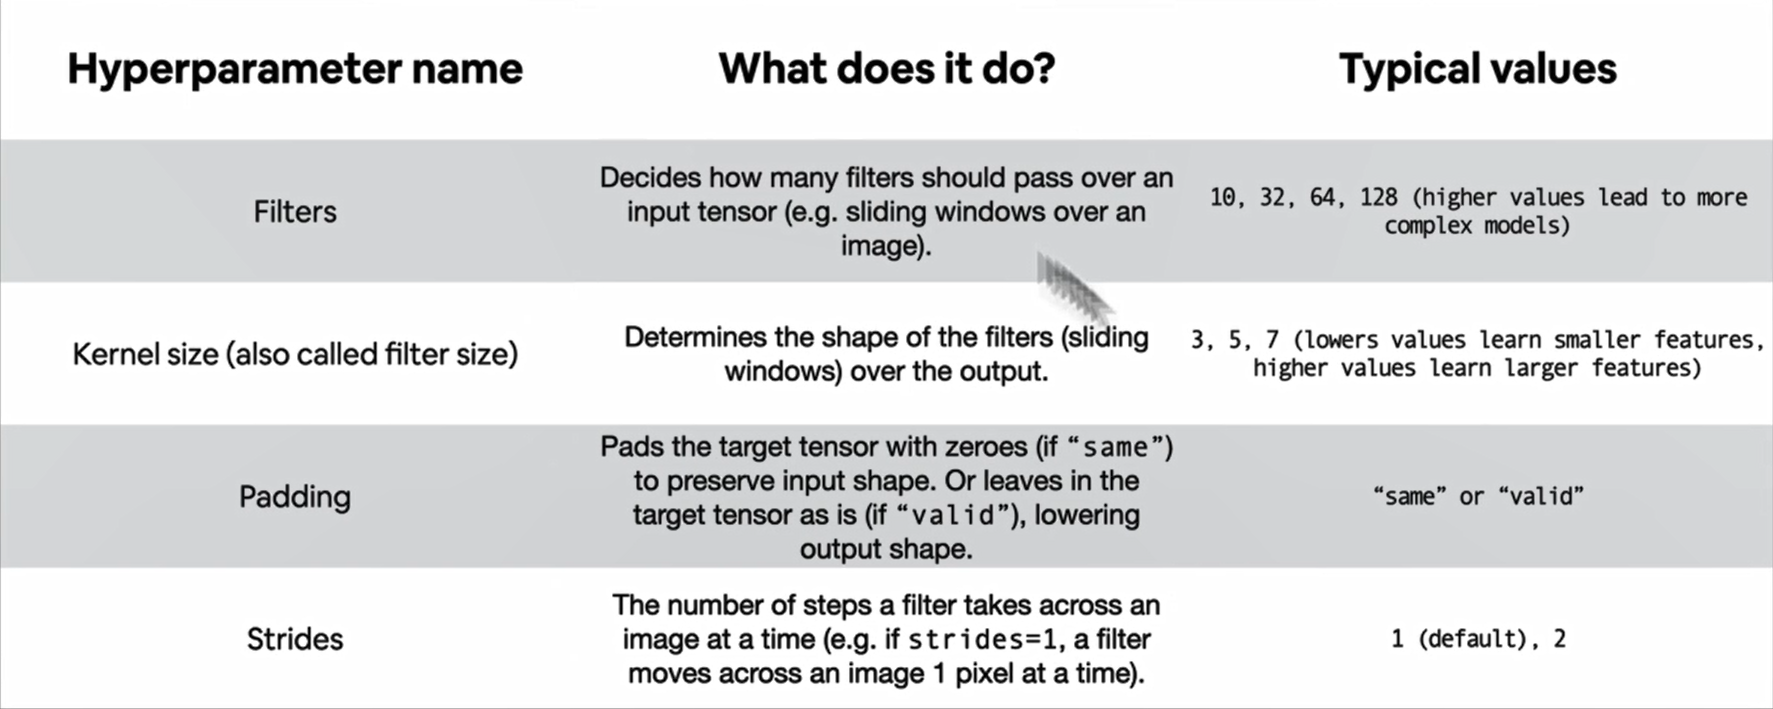

Use [CNN-Explainer](https://poloclub.github.io/cnn-explainer/) for better understanding of the hyper parameters.

**Conv2D layer**
1. **Padding:** if same out shape is same as input shape and if valid output shape is reduced
2. **Filter:** Filter is the number of the sliding windows going across an input (higher= more complex)
3. **Kernel_size:** The size of sliding window going across the input
4. **Strides:** The size of step the sliding window takes across an input

In [ ]:
model5.compile(loss='binary_crossentropy',
               optimizer=Adam(),
               metrics=['accuracy']) 

### 4. Fit the model

In [ ]:
history5=model5.fit(train_data,
                  epochs=5,
                  steps_per_epoch=len(train_data), #how many batches you want to go through
                  validation_data=test_data,
                  validation_steps=len(test_data)) #how many batches of validation data

### 5. Evaluate Model

In [ ]:
import pandas as pd

pd.DataFrame(history5.history).plot()

In [ ]:
def plot_loss_curves(history):
  '''Returns sperate loss curves'''
  loss=history.history['loss']
  val_loss=history.history['val_loss']
  accuracy=history.history['accuracy']
  val_accuracy=history.history['val_accuracy']
  epochs=range(len(history.history['loss']))
  plt.figure()
  #plot loss
  plt.plot(epochs,loss,label='Training loss')
  plt.plot(epochs,val_loss,label="Validation loss")
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.figure()
  #plot accuracy
  plt.plot(epochs,accuracy,label='Training accuracy')
  plt.plot(epochs,val_accuracy,label="Validation accuracy")
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

In [ ]:
plot_loss_curves(history5)

**Note:** When a model's **validation loss starts to increase**, It's likely that the model is **overfitting** the training dataset. This means, it's learning the patterns in the dataset **too well** and thus the model's ability to generalize the unseen data is being diminished

###5. Adjust the model parameters

**Fitting a machine learning model comes usually in 3 steps:**
1. Create baseline
2. Beat the baseline by overfitting a larger model
3. Reduce overfitting

**Ways to introduce overfitting:**
* Increase the number of conv layers
* Increase the number of conv filters
* Add another dense layer to the output of our flattened layer

**Reduce Overfitting:**
* Add data augmentation
* Add regularization layers (such as maxpool2d)
* Add more data

**Reducing overfitting is also called regularization**

In [ ]:
model6=Sequential([
  Conv2D(10,3,activation='relu',input_shape=(224,224,3)), #padding is valid and strides=1 by def
  MaxPool2D(pool_size=2),
  Conv2D(10,3,activation='relu'),
  MaxPool2D(),
  Conv2D(10,3,activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1,activation='sigmoid')

])

**What MaxPool2D layer is doing?**

Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input. The window is shifted by strides along each dimension.

Since our pool_size is 2 here it takes a 2x2 matrix and outputs the maximum of 4 inputted values in a matrix.

Strides in this layer are None by default so no gap between the pool.

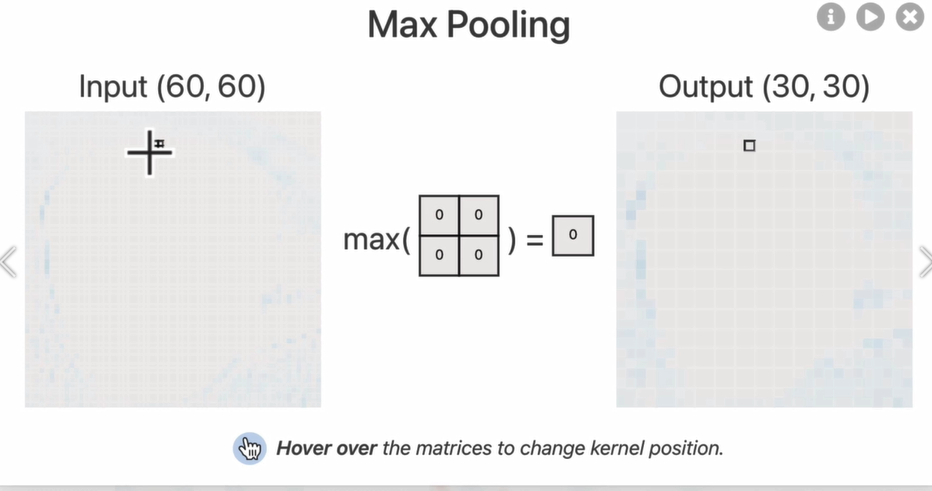

In [ ]:
model6.compile(loss='binary_crossentropy',
               optimizer=Adam(),
               metrics='accuracy')

In [ ]:
history6=model6.fit(train_data,
                    epochs=5,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=len(test_data))

In [ ]:
model5.evaluate(test_data),model6.evaluate(test_data)

By adding maxpooling layers we have increased accuracy by 7%

Although the accuracy on training data has decreased but accuracy on testing data is increased which means the model is not overfitting now

In [ ]:
plot_loss_curves(history6)

We can see that validation loss is decreasing now instead of increasing like before

In [ ]:
model5.summary()

In [ ]:
model6.summary()

Not only we reduced the overfitting but the trainable parameters have also been reduced.

Notice First Conv2D layer output shape is (None,222,222,10)
but maxpooling layer has halved it by (111,111,10)
then conv2D layer outputs (109,109,10)
and maxpooling halves it again to (54,54,10) but the case is different in case of model5

### Opening our bag of tricks and find data augmentation

Read [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) parameters

In [ ]:
#Create ImageDataGenerator with augmentation
train_datagen_aug=ImageDataGenerator(rescale=1/255.,
                                     rotation_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     horizontal_flip=True)
#Create ImageDataGenerator without augmentation
train_datagen=ImageDataGenerator(rescale=1/255.)
test_datagen=ImageDataGenerator(rescale=1/255.)


**What is data augmentation?**

Data augmentation is the process of altering our **Training data**, leading it to have more diversity and in turn allowing our models to learn more generalizable patterns. Altering might mean adjusting the rotation of the image, flipping it, cropping it etc.

We might not need to get more data to for generalization because we are diversifying data ourselves

In [ ]:
#Import data and augment it from training data
print('Augmented Training data')
train_data_aug=train_datagen_aug.flow_from_directory(train_dir,
                                                     target_size=(224,224),
                                                     batch_size=32,
                                                     class_mode='binary',
                                                     shuffle=False)
#Shuffle is off only for demonstration its a good idea to introduce randomness

print('Non-Augmented Training data')
train_data=train_datagen.flow_from_directory(train_dir,
                                            target_size=(224,224),
                                            batch_size=32,
                                            class_mode='binary',
                                            shuffle=False)
print('Non-Augmented Training data')
test_data=test_datagen.flow_from_directory(test_dir,
                                           target_size=(224,224),
                                           batch_size=32,
                                           class_mode='binary')

Visualizing some augmented data

In [ ]:
images,label=train_data.next()
aug_images,aug_labels=train_data_aug.next()

In [ ]:
#Show original vs augmented images
import random
randint=random.randint(0,32)
print(f'Showing image number: {randint}')
plt.imshow(images[randint])
plt.title('Original Image')
plt.axis(False)

plt.figure()

plt.imshow(aug_images[randint])
plt.title('Augmented Image')
plt.axis(False)

In [ ]:
model7=Sequential([
  Conv2D(10,3,activation='relu',input_shape=(224,224,3)), #padding is valid and strides=1 by def
  MaxPool2D(pool_size=2),
  Conv2D(10,3,activation='relu'),
  MaxPool2D(),
  Conv2D(10,3,activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1,activation='sigmoid')

])

model7.compile(loss='binary_crossentropy',
               optimizer=Adam(),
               metrics=['accuracy'])

In [ ]:
history7=model7.fit(train_data_aug,
                    epochs=5,
                    steps_per_epoch=len(train_data_aug),
                    validation_data=test_data,
                    validation_steps=len(test_data))

In [ ]:
plot_loss_curves(history7)

We might've made learning too hard for our model but let's try to shuffle the data and see if it works

In [ ]:
 train_data_aug_shuff=train_datagen_aug.flow_from_directory(train_dir,
                                                     target_size=(224,224),
                                                     batch_size=32,
                                                     class_mode='binary',
                                                     shuffle=True)

In [ ]:
model8=Sequential([
  Conv2D(10,3,activation='relu',input_shape=(224,224,3)), #padding is valid and strides=1 by def
  MaxPool2D(pool_size=2),
  Conv2D(10,3,activation='relu'),
  MaxPool2D(),
  Conv2D(10,3,activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1,activation='sigmoid')

])

model8.compile(loss='binary_crossentropy',
               optimizer=Adam(),
               metrics=['accuracy'])

In [ ]:
history8=model8.fit(train_data_aug_shuff,
                    epochs=5,
                    steps_per_epoch=len(train_data_aug_shuff),
                    validation_data=test_data,
                    validation_steps=len(test_data))

Shuffling has improved the accuracy of our model.

Without shuffle model will learn from pizza/steak and then move on to steak/pizza but it has already learnt pizza/steak so it will try to adjust new class which will decrease performance badly. If we input shuffled data then pizza and steak classes mix so model can adjust to both at the same time

In [ ]:
plot_loss_curves(history8)

### Repeat until satisfied

* Increase number of model layers
* Increase number of filters
* Train for longer
* Find an ideal learning rate(default is fine right now)
* Get more data
* Use **Training learning** to leverage what another image model has learned to adjust for our own use case. (next module)

#### Try CNN explainer model on shuffled data

In [ ]:

model9=tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=10,
                         kernel_size=3,
                         activation='relu',
                         input_shape=(224,224,3)),
        tf.keras.layers.Conv2D(10,3,activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=2,
                           padding='valid'),
        tf.keras.layers.Conv2D(10,3,activation='relu'),
        tf.keras.layers.Conv2D(10,3,activation='relu'),
        tf.keras.layers.MaxPool2D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1,activation='sigmoid')
        ])

model9.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
history9=model9.fit(train_data_aug_shuff,
                    epochs=10,
                    steps_per_epoch=len(train_data_aug_shuff),
                    validation_data=test_data,
                    validation_steps=len(test_data))

Not much improvement compared to simple model

#### Increasing filters

In [ ]:

model10=tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=32,
                         kernel_size=3,
                         activation='relu',
                         input_shape=(224,224,3)),
        tf.keras.layers.Conv2D(32,3,activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=2,
                           padding='valid'),
        tf.keras.layers.Conv2D(32,3,activation='relu'),
        tf.keras.layers.Conv2D(32,3,activation='relu'),
        tf.keras.layers.MaxPool2D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1,activation='sigmoid')
        ])

model10.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
history10=model10.fit(train_data_aug_shuff,
                    epochs=10,
                    steps_per_epoch=len(train_data_aug_shuff),
                    validation_data=test_data,
                    validation_steps=len(test_data))

Some improvement

Using the same model without shuffled and augmented data

In [ ]:

model11=tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=32,
                         kernel_size=3,
                         activation='relu',
                         input_shape=(224,224,3)),
        tf.keras.layers.Conv2D(32,3,activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=2,
                           padding='valid'),
        tf.keras.layers.Conv2D(32,3,activation='relu'),
        tf.keras.layers.Conv2D(32,3,activation='relu'),
        tf.keras.layers.MaxPool2D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1,activation='sigmoid')
        ])

model11.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
history11=model11.fit(train_data,
                    epochs=10,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=len(test_data))

Worse results than the last model

#### Changing activation functions

In [ ]:

model12=tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=32,
                         kernel_size=3,
                         activation='tanh',
                         input_shape=(224,224,3)),
        tf.keras.layers.Conv2D(32,3,activation='tanh'),
        tf.keras.layers.MaxPool2D(pool_size=2,
                           padding='valid'),
        tf.keras.layers.Conv2D(32,3,activation='tanh'),
        tf.keras.layers.Conv2D(32,3,activation='tanh'),
        tf.keras.layers.MaxPool2D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1,activation='sigmoid')
        ])

model12.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
history12=model12.fit(train_data_aug_shuff,
                    epochs=10,
                    steps_per_epoch=len(train_data_aug_shuff),
                    validation_data=test_data,
                    validation_steps=len(test_data))

worsened the model

#### Adding more layers

In [ ]:

model13=tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=32,
                         kernel_size=3,
                         activation='relu',
                         input_shape=(224,224,3)),
        tf.keras.layers.Conv2D(32,3,activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=2,
                           padding='valid'),
        tf.keras.layers.Conv2D(32,3,activation='relu'),
        tf.keras.layers.Conv2D(32,3,activation='relu'),
        tf.keras.layers.MaxPool2D(2),
        tf.keras.layers.Conv2D(32,3,activation='relu'),
        tf.keras.layers.Conv2D(32,3,activation='relu'),
        tf.keras.layers.MaxPool2D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1,activation='sigmoid')
        ])

model13.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
history13=model13.fit(train_data_aug_shuff,
                    epochs=15,
                    steps_per_epoch=len(train_data_aug_shuff),
                    validation_data=test_data,
                    validation_steps=len(test_data))

After testing model 10 is still the best model right now

#### Training model10 for more epochs

In [ ]:

model14=tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=32,
                         kernel_size=3,
                         activation='relu',
                         input_shape=(224,224,3)),
        tf.keras.layers.Conv2D(32,3,activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=2,
                           padding='valid'),
        tf.keras.layers.Conv2D(32,3,activation='relu'),
        tf.keras.layers.Conv2D(32,3,activation='relu'),
        tf.keras.layers.MaxPool2D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1,activation='sigmoid')
        ])

model14.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
history14=model14.fit(train_data_aug_shuff,
                    epochs=15,
                    steps_per_epoch=len(train_data_aug_shuff),
                    validation_data=test_data,
                    validation_steps=len(test_data))

### Comparing all the models we have created so far

In [ ]:
history.history['loss']

In [ ]:
histories=[history.history,history2.history,history3.history,history4.history,
           history5.history,history6.history,history7.history,history8.history,
           history9.history,history10.history,history11.history,history12.history,
           history13.history,history14.history]

In [ ]:
hist=[]
for x in histories:
  dic={}
  dic['loss']=x['loss'][-1]
  dic['accuracy']=x['accuracy'][-1]
  dic['val_loss']=x['val_loss'][-1]
  dic['val_accuracy']=x['val_accuracy'][-1]
  dic['epochs']=len(x['loss'])
  hist.append(dic)

In [ ]:
import pandas as pd
performances=pd.DataFrame(hist)

Graph shows that training and validation accuracy on model 9.

In [ ]:
performances

we can see that the val_accuracy of model 10(index 9) is the highest 93.5 with 85.3 training accuracy.

In [ ]:
index=performances['val_accuracy'].argmax()
performances['val_accuracy'].max(),performances['accuracy'][index],index

## Making a prediction with our trained model on our custom data

In [ ]:
print(class_names)

In [ ]:
#getting the image

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
steak=mpimg.imread('03-steak.jpeg')

In [ ]:
plt.imshow(steak)
plt.axis(False)

We cannot pass this directly to our model since it's shape is not compatible with our model and the pixels values are not rescaled

In [ ]:
#creating a function to import the image and resize it to able to be used with our
#model

def load_prep_image(filename,img_shape=224):
  '''Read a image from the filename and turns it into a tensor and reshapes it
  to (img_shape,img_shape,color_channels)'''
  img=tf.io.read_file(filename)
  img=tf.image.decode_image(img)
  #resize
  img=tf.image.resize(img,[img_shape,img_shape])
  #rescaling image pixel values
  img=img/255.
  return img

In [ ]:
image=load_prep_image('03-steak.jpeg',224)

Let's give to our model and predict

we need to expand the dims because previously we passed 32 images in a single batch which makes its shape (32,224,224,3) so expanding dim will make (224,224,3) to (1,224,224,3) which our model can accept

In [ ]:
pred=model10.predict(tf.expand_dims(image,axis=0))

It is just showing the prediction probability. It would be better to get class names.

We can index the predicted class by rounding the prediction probability and use it to index class_names

In [ ]:
pred_class=class_names[int(tf.round(pred))]

In [ ]:
pred_class

In [ ]:
def pred_plot(model,filename,class_names=class_names):
  '''Imports an image located at filename,makes a prediction with model and plots
  the image with predicted class as the title'''
  #load and prep image
  img=load_prep_image(filename)

  #prediction
  pred=model.predict(tf.expand_dims(img,axis=0))

  #get the class
  pred_class=class_names[int(tf.round(pred))]

  #plot the image and predicted class
  plt.imshow(img)
  plt.title(f"prediction: {pred_class}")
  plt.axis(False)


In [ ]:
pred_plot(model=model3,filename='03-steak.jpeg')

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg

In [ ]:
pred_plot(model=model10,filename='03-pizza-dad.jpeg')

#Multi-class Image Classification

1. Become one with the data.
2. Preprocess the data(get it ready for the model)
3. Create a model(create a model)
4. Fit the model
5. Evaluate the model
6. Adjust different hyperparameters and improve the model (try to beat baseline/reduce overfitting)
7. Repeat until satisfied

##Import and become one with the data

In [ ]:
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

--2022-07-14 08:26:20--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.251.10.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: â€˜10_food_classes_all_data.zipâ€™

10_food_classes_all 100%[===================>] 495.13M   186MB/s    in 2.7s    

2022-07-14 08:26:23 (186 MB/s) - â€˜10_food_classes_all_data.zipâ€™ saved [519183241/519183241]



In [ ]:
zip_ref=zipfile.ZipFile('10_food_classes_all_data.zip')
zip_ref.extractall()
zip_ref.close()

In [ ]:
import os

#walk through 10 classes of food image data

for dirpath,dirnames,filenames in os.walk('10_food_classes_all_data'):
  print(f'There are {len(dirnames)} directories and {len(filenames)} in {dirpath} ')

There are 2 directories and 0 in 10_food_classes_all_data 
There are 10 directories and 0 in 10_food_classes_all_data/test 
There are 0 directories and 250 in 10_food_classes_all_data/test/sushi 
There are 0 directories and 250 in 10_food_classes_all_data/test/pizza 
There are 0 directories and 250 in 10_food_classes_all_data/test/hamburger 
There are 0 directories and 250 in 10_food_classes_all_data/test/ice_cream 
There are 0 directories and 250 in 10_food_classes_all_data/test/ramen 
There are 0 directories and 250 in 10_food_classes_all_data/test/grilled_salmon 
There are 0 directories and 250 in 10_food_classes_all_data/test/chicken_wings 
There are 0 directories and 250 in 10_food_classes_all_data/test/steak 
There are 0 directories and 250 in 10_food_classes_all_data/test/fried_rice 
There are 0 directories and 250 in 10_food_classes_all_data/test/chicken_curry 
There are 10 directories and 0 in 10_food_classes_all_data/train 
There are 0 directories and 750 in 10_food_classes_a

In [ ]:
!ls -ls 10_food_classes_all_data

total 8
4 drwxr-xr-x 12 root root 4096 Jul 14 08:26 test
4 drwxr-xr-x 12 root root 4096 Jul 14 08:26 train


In [ ]:
#setup train and test dir
train_dir='10_food_classes_all_data/train/'
test_dir='10_food_classes_all_data/test'

In [ ]:
#getting classnames
import pathlib
import numpy as np
data_dir=pathlib.Path(train_dir) 
class_names=np.array(sorted(item.name for item in data_dir.glob('*')))

In [ ]:
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

image shape : (512, 512, 3)


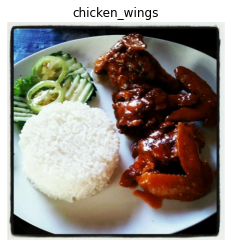

In [ ]:
import random
view_random_image(train_dir,random.choice(class_names))

##Preprocess the data (Prepare it for the model)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_gen=ImageDataGenerator(rescale=1/255.0)
test_gen=ImageDataGenerator(rescale=1/255.0)

In [ ]:
train_data=train_gen.flow_from_directory(train_dir,
                                         target_size=(224,224),
                                        class_mode='categorical',
                                         batch_size=32)
test_data=test_gen.flow_from_directory(test_dir,
                                         target_size=(224,224),
                                        class_mode='categorical',
                                         batch_size=32)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Create a model( start with a base line)

In [ ]:
import tensorflow as tf
#Build a CNN model
#model can still be improved by adding more units and increasing the image input
#size
tf.random.set_seed(42)
model=tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=10,
                         kernel_size=3,
                         activation='relu',
                         input_shape=(224,224,3)),
        tf.keras.layers.Conv2D(10,3,activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=2,
                           padding='valid'),
        tf.keras.layers.Conv2D(10,3,activation='relu'),
        tf.keras.layers.Conv2D(10,3,activation='relu'),
        tf.keras.layers.MaxPool2D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10,activation='softmax')
        ])

#Compile
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
history=model.fit(train_data, epochs=5,
          steps_per_epoch=len(train_data),
          validation_data=test_data,
          validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 58s 196ms/step - loss: 2.1237 - accuracy: 0.2221 - val_loss: 1.9640 - val_accuracy: 0.2972
Epoch 2/5
235/235 [==============================] - 45s 191ms/step - loss: 1.9289 - accuracy: 0.3273 - val_loss: 1.9745 - val_accuracy: 0.2968
Epoch 3/5
235/235 [==============================] - 46s 194ms/step - loss: 1.7080 - accuracy: 0.4247 - val_loss: 1.9337 - val_accuracy: 0.3348
Epoch 4/5
235/235 [==============================] - 45s 189ms/step - loss: 1.2609 - accuracy: 0.5768 - val_loss: 2.0911 - val_accuracy: 0.3320
Epoch 5/5
235/235 [==============================] - 44s 189ms/step - loss: 0.6796 - accuracy: 0.7811 - val_loss: 2.8708 - val_accuracy: 0.2708


Even though the accuracy is 85 percent but the validation accuracy is just near 30 percent. Is our model even learning anything? since there are 10 classes guessing would be near 10 percent(100/10) so yes, it is

##Evaluate the model

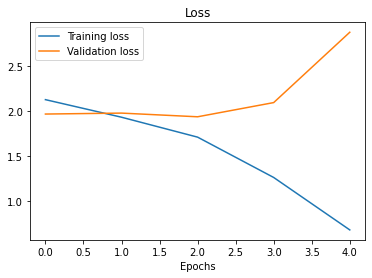

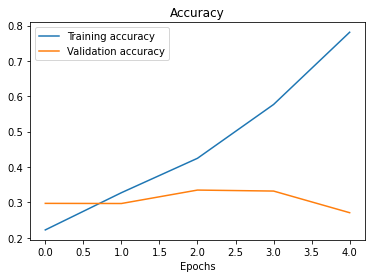

In [ ]:
#loss and accuracy curve
plot_loss_curves(history)

Loss and accuracy curves tell us that the model is overfitting, meaning it is learning the training data too well but is not able to generalize it enough for the unseen images

In [ ]:
model.evaluate(test_data)

79/79 [==============================] - 11s 134ms/step - loss: 2.8708 - accuracy: 0.2708


[2.870837450027466, 0.27079999446868896]

##Adjust different hyperparameters

Since there was overfitting in the last model, let's reduce it this time.
How to reduce overfitting?

* **Get more data** - having more data means model can learn from diverse data
* **Simplify the model** - the model might be too complicated, one way to simplify a model is to : reduce the # of layers or reduce # no of hidden units in layers
* **Use data Augmentation** - Data augmentation creates diversity in the data

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

###Decreasing no of conv layers

In [ ]:

tf.random.set_seed(42)
model2=tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=10,
                         kernel_size=3,
                         activation='relu',
                         input_shape=(224,224,3)),
        tf.keras.layers.MaxPool2D(pool_size=2,
                           padding='valid'),
        tf.keras.layers.Conv2D(10,3,activation='relu'),
        tf.keras.layers.MaxPool2D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10,activation='softmax')
        ])

#Compile
model2.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 10)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 10)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 29160)             0         
                                                                 
 dense_1 (Dense)             (None, 10)               

Number of parameters havent changed that much but lets experiment

In [ ]:
history2=model2.fit(train_data,
           epochs=5,
           steps_per_epoch=len(train_data),
           validation_data=test_data,
           validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 44s 183ms/step - loss: 2.1006 - accuracy: 0.2476 - val_loss: 1.9047 - val_accuracy: 0.3508
Epoch 2/5
235/235 [==============================] - 43s 184ms/step - loss: 1.7964 - accuracy: 0.3905 - val_loss: 1.8497 - val_accuracy: 0.3516
Epoch 3/5
235/235 [==============================] - 42s 180ms/step - loss: 1.4776 - accuracy: 0.5092 - val_loss: 1.9419 - val_accuracy: 0.3408
Epoch 4/5
235/235 [==============================] - 43s 181ms/step - loss: 1.0385 - accuracy: 0.6720 - val_loss: 2.0761 - val_accuracy: 0.3336
Epoch 5/5
235/235 [==============================] - 42s 181ms/step - loss: 0.5905 - accuracy: 0.8308 - val_loss: 2.4048 - val_accuracy: 0.3188


Not much of a difference from the last model. We could tell since the number of the parameters didn't decrease.

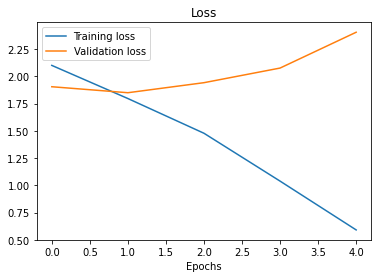

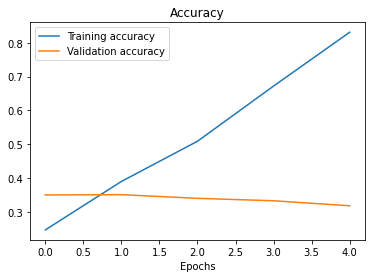

In [ ]:
plot_loss_curves(history2)

Since this didn't work, let's perform data augmentation

### Data Augmentation

In [ ]:
#Create ImageDataGenerator with augmentation
train_datagen_aug=ImageDataGenerator(rescale=1/255.,
                                     rotation_range=0.2,
                                     zoom_range=0.2,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1/255.)


In [ ]:
train_data_aug=train_datagen_aug.flow_from_directory(train_dir,
                                         target_size=(224,224),
                                        class_mode='categorical',
                                         batch_size=32)
test_data=test_datagen.flow_from_directory(test_dir,
                                         target_size=(224,224),
                                        class_mode='categorical',
                                         batch_size=32)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [ ]:
#cloning model only copies the structure not anything it has learnt 
model3=tf.keras.models.clone_model(model)

#compiling
model3.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

In [ ]:
history3=model3.fit(train_data_aug,
                    epochs=5,
                    steps_per_epoch=len(train_data_aug),
                    validation_data=test_data,
                    validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 111s 471ms/step - loss: 2.2593 - accuracy: 0.1453 - val_loss: 2.1543 - val_accuracy: 0.1912
Epoch 2/5
235/235 [==============================] - 111s 472ms/step - loss: 2.1734 - accuracy: 0.1920 - val_loss: 2.0953 - val_accuracy: 0.2236
Epoch 3/5
235/235 [==============================] - 112s 475ms/step - loss: 2.1187 - accuracy: 0.2319 - val_loss: 2.0558 - val_accuracy: 0.2628
Epoch 4/5
235/235 [==============================] - 110s 466ms/step - loss: 2.0595 - accuracy: 0.2716 - val_loss: 1.9147 - val_accuracy: 0.3464
Epoch 5/5
235/235 [==============================] - 111s 471ms/step - loss: 2.0101 - accuracy: 0.2913 - val_loss: 1.8638 - val_accuracy: 0.3660


In [ ]:
model3.evaluate(test_data)

79/79 [==============================] - 11s 135ms/step - loss: 1.8638 - accuracy: 0.3660


[1.8638384342193604, 0.3659999966621399]

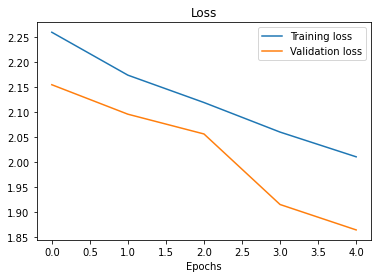

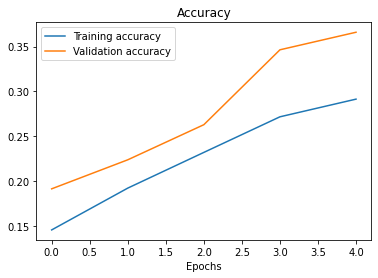

In [ ]:
plot_loss_curves(history3)

Curve is looking alot better this time, both training loss and validation loss is decreasing.
Let's train it for longer

In [ ]:
history3=model3.fit(train_data_aug,
                    epochs=5,
                    steps_per_epoch=len(train_data_aug),
                    validation_data=test_data,
                    validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 110s 469ms/step - loss: 1.9442 - accuracy: 0.3169 - val_loss: 1.8286 - val_accuracy: 0.3612
Epoch 2/5
235/235 [==============================] - 109s 464ms/step - loss: 1.9395 - accuracy: 0.3287 - val_loss: 1.8591 - val_accuracy: 0.3388
Epoch 3/5
235/235 [==============================] - 110s 469ms/step - loss: 1.9009 - accuracy: 0.3411 - val_loss: 1.7448 - val_accuracy: 0.4060
Epoch 4/5
235/235 [==============================] - 109s 465ms/step - loss: 1.8981 - accuracy: 0.3409 - val_loss: 1.7543 - val_accuracy: 0.3884
Epoch 5/5
235/235 [==============================] - 109s 464ms/step - loss: 1.8706 - accuracy: 0.3540 - val_loss: 1.7069 - val_accuracy: 0.4036


In [ ]:
model3.evaluate(test_data)

79/79 [==============================] - 11s 133ms/step - loss: 1.7069 - accuracy: 0.4036


[1.7069052457809448, 0.4036000072956085]

Model has improved alot. Let's train it for a little longer to check if there is any improvment is made.

In [ ]:
history3=model3.fit(train_data_aug,
                    epochs=5,
                    steps_per_epoch=len(train_data_aug),
                    validation_data=test_data,
                    validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 110s 469ms/step - loss: 1.8658 - accuracy: 0.3528 - val_loss: 1.7438 - val_accuracy: 0.3972
Epoch 2/5
235/235 [==============================] - 110s 468ms/step - loss: 1.8336 - accuracy: 0.3652 - val_loss: 1.7080 - val_accuracy: 0.4136
Epoch 3/5
235/235 [==============================] - 109s 463ms/step - loss: 1.8245 - accuracy: 0.3732 - val_loss: 1.7249 - val_accuracy: 0.4136
Epoch 4/5
235/235 [==============================] - 110s 466ms/step - loss: 1.8183 - accuracy: 0.3776 - val_loss: 1.6943 - val_accuracy: 0.4156
Epoch 5/5
235/235 [==============================] - 109s 464ms/step - loss: 1.8103 - accuracy: 0.3755 - val_loss: 1.6559 - val_accuracy: 0.4300


Even tho the training accuracy has improved a bit but the validation accuracy has stayed the same (or decreased)

##Repeat until satisfied
 * train for longer
 * increasing pooling layers
 * Adjust learning rates
 * Try different types of data augmentation (adjust the hyperparameter of ImageDataGenerator)

Let's try increasing the pooling layers and increasing learning rate

In [ ]:
import tensorflow as tf
#Build a CNN model
#model can still be improved by adding more units and increasing the image input
#size
tf.random.set_seed(42)
model4=tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=10,
                         kernel_size=3,
                         activation='relu',
                         input_shape=(224,224,3)),
        tf.keras.layers.Conv2D(10,3,activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=2,
                           padding='valid'),
        tf.keras.layers.Conv2D(10,3,activation='relu'),
        tf.keras.layers.MaxPool2D(2),
        tf.keras.layers.Conv2D(10,3,activation='relu'),
        tf.keras.layers.MaxPool2D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10,activation='softmax')
        ])

#Compile
model4.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
model4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_7 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 110, 110, 10)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 10)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 52, 52, 10)       

In [ ]:
history4=model4.fit(train_data_aug, epochs=5,
          steps_per_epoch=len(train_data_aug),
          validation_data=test_data,
          validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 110s 466ms/step - loss: 2.2127 - accuracy: 0.1633 - val_loss: 2.0890 - val_accuracy: 0.2440
Epoch 2/5
235/235 [==============================] - 108s 458ms/step - loss: 2.0940 - accuracy: 0.2487 - val_loss: 1.9427 - val_accuracy: 0.3124
Epoch 3/5
235/235 [==============================] - 109s 463ms/step - loss: 2.0367 - accuracy: 0.2768 - val_loss: 1.9234 - val_accuracy: 0.3248
Epoch 4/5
235/235 [==============================] - 109s 462ms/step - loss: 1.9810 - accuracy: 0.3065 - val_loss: 1.8484 - val_accuracy: 0.3688
Epoch 5/5
235/235 [==============================] - 110s 469ms/step - loss: 1.9361 - accuracy: 0.3257 - val_loss: 1.7701 - val_accuracy: 0.3936


Looks like it didnt do anything. It made our model worse

##Making a prediction with our trained model

In [ ]:
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-sushi.jpeg
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg

--2022-07-14 09:21:12--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: â€˜03-pizza-dad.jpegâ€™

03-pizza-dad.jpeg   100%[===================>]   2.74M  --.-KB/s    in 0.01s   

2022-07-14 09:21:12 (220 MB/s) - â€˜03-pizza-dad.jpegâ€™ saved [2874848/2874848]

--2022-07-14 09:21:12--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, await

In [ ]:
#make a prediction using model 3
pred_plot(model3,'03-pizza-dad.jpeg',class_names)

TypeError: ignored

Pred_plot only works with binary images. Let's reconfigure it to work with multiclass

In [ ]:
def pred_plot(model,filename,class_names=class_names):
  '''Imports an image located at filename,makes a prediction with model and plots
  the image with predicted class as the title'''
  #load and prep image
  img=load_prep_image(filename)

  #prediction
  pred=model.predict(tf.expand_dims(img,axis=0))
  #get the class
  if len(pred[0])>1:
    pred_class=class_names[tf.argmax(pred[0])]
  else:
    pred_class=class_names[int(tf.round(pred))]

  #plot the image and predicted class
  plt.imshow(img)
  plt.title(f"prediction: {pred_class}")
  plt.axis(False)


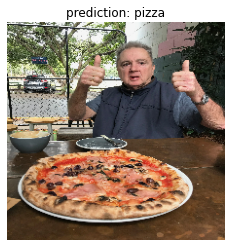

In [ ]:
#make a prediction using model 3
pred_plot(model3,'03-pizza-dad.jpeg',class_names)

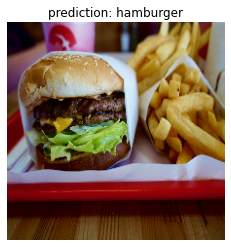

In [ ]:

pred_plot(model3,'03-hamburger.jpeg',class_names)

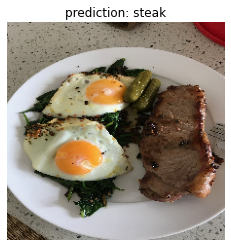

In [ ]:

pred_plot(model3,'03-steak.jpeg',class_names)

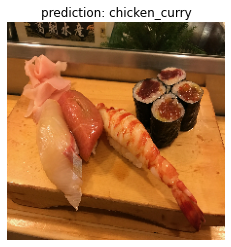

In [ ]:
pred_plot(model3,'03-sushi.jpeg',class_names)

It got three of them right

##Saving and loading model

###Saving model

In [ ]:
model3.save('saved_train_model_3')

INFO:tensorflow:Assets written to: saved_train_model_3/assets


###Loading model 

In [ ]:
loaded_model3=tf.keras.models.load_model('saved_train_model_3')

In [ ]:
loaded_model3.evaluate(test_data)

79/79 [==============================] - 14s 177ms/step - loss: 1.6559 - accuracy: 0.4300


[1.655930995941162, 0.4300000071525574]

In [ ]:
model3.evaluate(test_data)

79/79 [==============================] - 11s 134ms/step - loss: 1.6559 - accuracy: 0.4300


[1.6559306383132935, 0.4300000071525574]